In [3]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import tqdm

matplotlib.style.use('ggplot')

In [4]:
env = BlackjackEnv()

In [40]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    """
    Monte Carlo prediction algorithm. Calculates the value function
    for a given policy using sampling.
    
    Args:
        policy: A function that maps an observation to action probabilities.
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
    
    Returns:
        A dictionary that maps from state -> value.
        The state is a tuple and the value is a float.
    """

    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final value function
    V = defaultdict(float)
    
    for episode in tqdm.tqdm(range(num_episodes)):
        ''' for each state in a sample:
                1. update the number of times we've seen it
                2. update the sum of returns for that state.
        '''
        done = False
        seq = []
        state = env.reset()
        states_seen = set()
        while not done:
            action = policy(state)
            new_state, reward, done, info = env.step(action)
            seq.append([state, reward])
            if state not in states_seen:
                states_seen.add(state)
            state = new_state
        
        for state in states_seen:
            for step_no in range(len(seq)):
                if seq[step_no][0] == state:
                    returns_count[seq[step_no][0]] += 1
                    for disc, next_step in enumerate(range(step_no, len(seq)), 0):
                        returns_sum[seq[step_no][0]] += (discount_factor ** disc) * seq[next_step][1]
                    break
                    
        for state in states_seen:
            V[state] = returns_sum[state]/returns_count[state]    
    
    return V    

In [38]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 6409.54it/s]


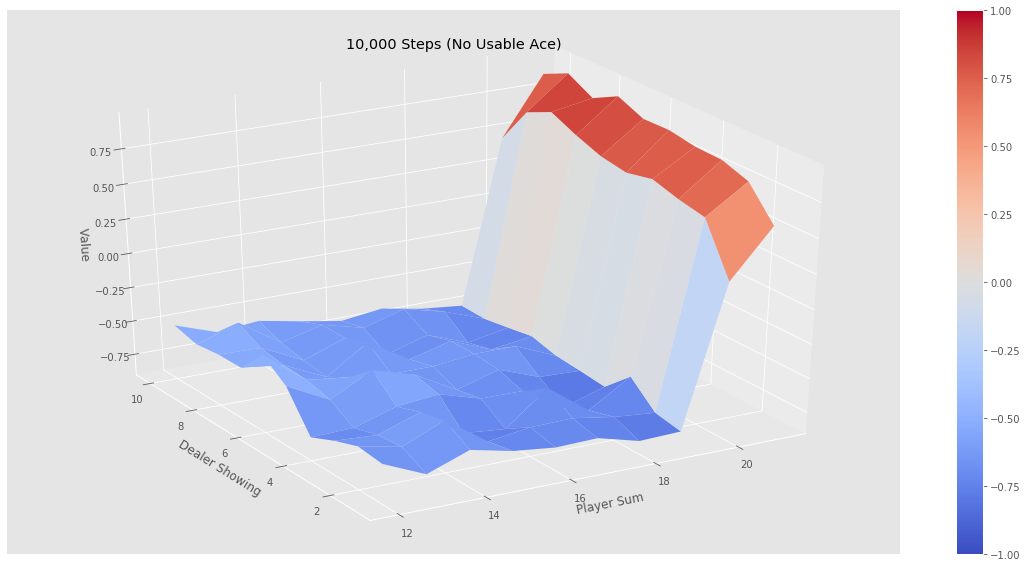

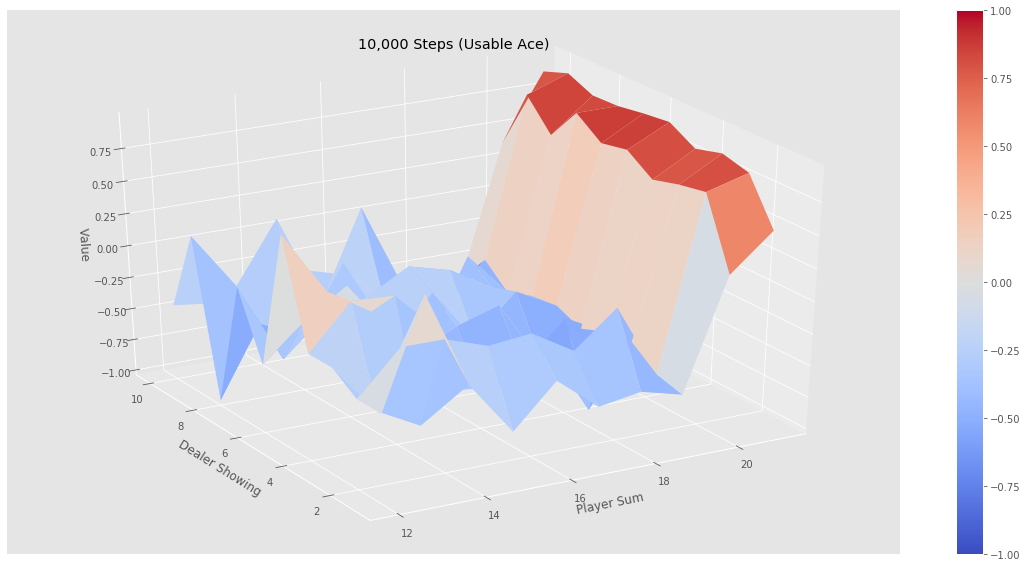

100%|████████████████████████████████████████████████████████████████████████| 500000/500000 [01:23<00:00, 6021.18it/s]


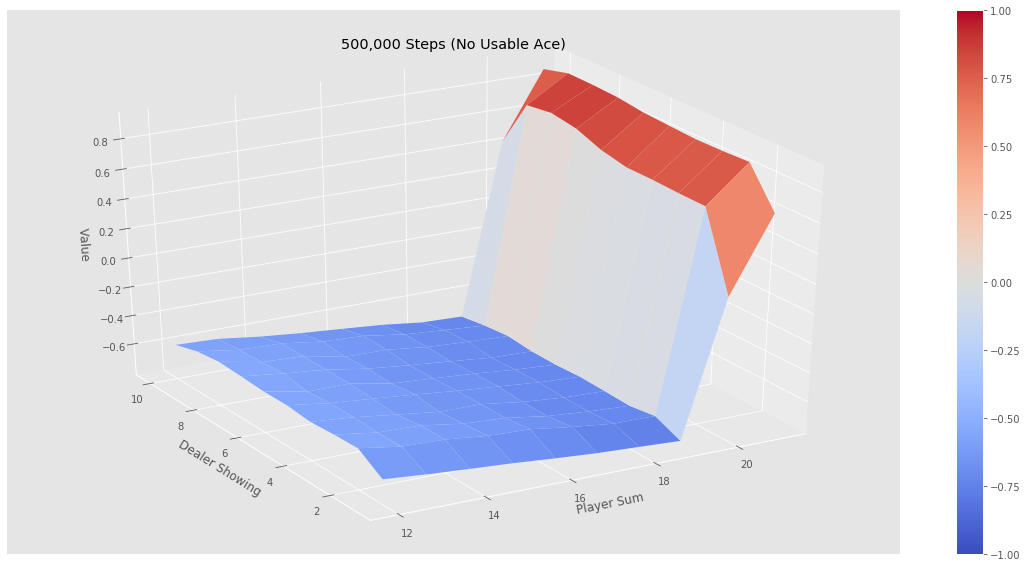

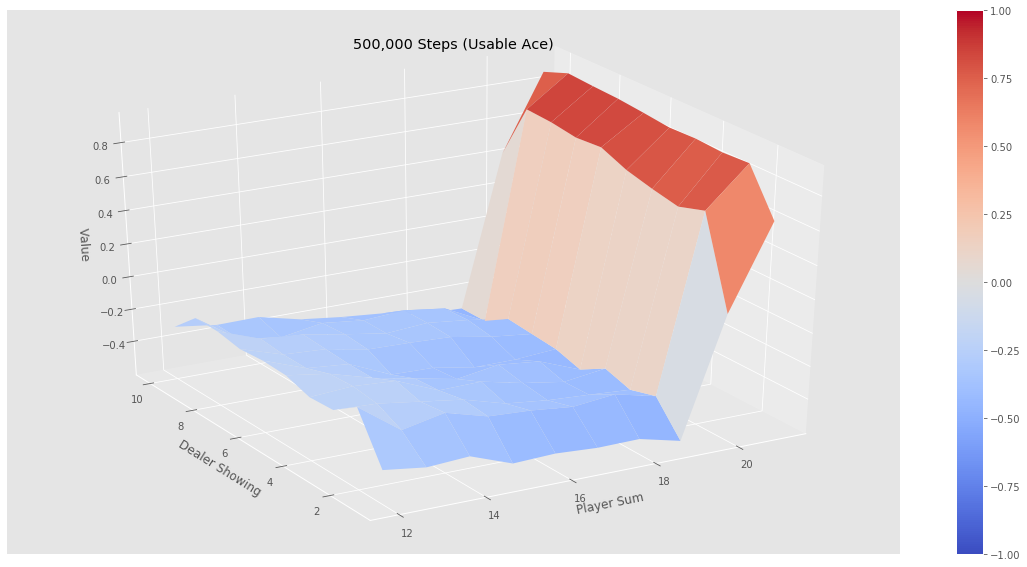

In [39]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")